In [1]:
import chromadb
import numpy as np

CHROMA_PATH="../chroma_db"
client = chromadb.PersistentClient(path=CHROMA_PATH)

collection_train=client.get_collection(name="airline_train_embeddings")
collection_test=client.get_collection(name="airline_test_embeddings")

def load_data(collection):
    data = collection.get(include=["embeddings",'metadatas'])

    embeddings=data['embeddings']
    labels=[item['airline_sentiment'] for item in data['metadatas']]

    return np.array(embeddings) , np.array(labels)

X_train,y_train=load_data(collection_train)
X_test,y_test=load_data(collection_test)

print(f"\nX_train shape: {X_train.shape} (Features)")
print(f"y_train shape: {y_train.shape} (Labels)")


X_train shape: (11541, 384) (Features)
y_train shape: (11541,) (Labels)


In [2]:
from sklearn.preprocessing import LabelEncoder

encoder=LabelEncoder()
y_train_encoded=encoder.fit_transform(y_train)
y_test_encoded=encoder.fit_transform(y_test)

classes=encoder.classes_.astype(str)

print(f"Encoded classes : {classes}")

Encoded classes : ['negative' 'neutral' 'positive']


**Entrainement de modele et evaluation sans optimisation de modele**

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)

        **Définition des modèles**

In [4]:
models={
    "LogisticRegression":LogisticRegression(max_iter=100,class_weight="balanced"),
    "SVM":SVC(kernel='linear',class_weight="balanced",probability=True),
    "XGBOOST":XGBClassifier(
        use_label_encoder=False,
        eval_metric='mlogloss',
        n_estimators=500,
        max_depth=5,
        random_state=42
    )
}

        Fonction pour évaluer modèle

In [5]:
def evaluate_model(model, X_train, y_train, X_test, y_test, classes, sample_weight=None):
    # Entraînement
    if sample_weight is not None:
        model.fit(X_train, y_train, sample_weight=sample_weight)
    else:
        model.fit(X_train, y_train)
    
    # Prédictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Metrics train
    metrics_train = {
        'accuracy': accuracy_score(y_train, y_train_pred),
        'precision_macro': precision_score(y_train, y_train_pred, average="macro"),
        'recall_macro': recall_score(y_train, y_train_pred, average="macro"),
        'f1_macro': f1_score(y_train, y_train_pred, average="macro"),
        'precision_weighted': precision_score(y_train, y_train_pred, average="weighted"),
        'recall_weighted': recall_score(y_train, y_train_pred, average="weighted"),
        'f1_weighted': f1_score(y_train, y_train_pred, average="weighted")
    }
    
    # Metrics test
    metrics_test = {
        'accuracy': accuracy_score(y_test, y_test_pred),
        'precision_macro': precision_score(y_test, y_test_pred, average="macro"),
        'recall_macro': recall_score(y_test, y_test_pred, average="macro"),
        'f1_macro': f1_score(y_test, y_test_pred, average="macro"),
        'precision_weighted': precision_score(y_test, y_test_pred, average="weighted"),
        'recall_weighted': recall_score(y_test, y_test_pred, average="weighted"),
        'f1_weighted': f1_score(y_test, y_test_pred, average="weighted")
    }
    
    # Gap train-test
    gap = {k: metrics_train[k] - metrics_test[k] for k in metrics_train}
    
    # Affichage
    print("\nClassification Report (Test):")
    print(classification_report(y_test, y_test_pred, target_names=classes))
    print("Confusion Matrix (Test):")
    print(confusion_matrix(y_test, y_test_pred))
    
    return metrics_train, metrics_test, gap

        Entraînement et évaluation

In [6]:
results = {}

for name, model in models.items():
    print(f"\n=== {name} ===")
    
    # Sample weights pour XGBoost seulement
    if name == "XGBoost":
        sample_weights = compute_sample_weight("balanced", y_train_encoded)
    else:
        sample_weights = None
    
    train_metrics, test_metrics, gap = evaluate_model(
        model, X_train, y_train_encoded, X_test, y_test_encoded, classes,
        sample_weight=sample_weights
    )
    
    results[name] = {
        'train': train_metrics,
        'test': test_metrics,
        'gap': gap
    }
    
    # Affichage résumé
    print("\n Metrics Summary:")
    print(f"Train Accuracy: {train_metrics['accuracy']:.4f}")
    print(f"Test Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"Train-Test Accuracy Gap: {gap['accuracy']:.4f}")
    print(f"Train F1 (weighted): {train_metrics['f1_weighted']:.4f}")
    print(f"Test F1 (weighted): {test_metrics['f1_weighted']:.4f}")
    print(f"Train-Test F1 Gap: {gap['f1_weighted']:.4f}")


=== LogisticRegression ===


c:\Users\elabi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Classification Report (Test):
              precision    recall  f1-score   support

    negative       0.91      0.81      0.85      1816
     neutral       0.57      0.68      0.62       612
    positive       0.65      0.78      0.71       458

    accuracy                           0.77      2886
   macro avg       0.71      0.75      0.73      2886
weighted avg       0.80      0.77      0.78      2886

Confusion Matrix (Test):
[[1463  253  100]
 [ 106  417   89]
 [  40   62  356]]

 Metrics Summary:
Train Accuracy: 0.8089
Test Accuracy: 0.7748
Train-Test Accuracy Gap: 0.0342
Train F1 (weighted): 0.8151
Test F1 (weighted): 0.7818
Train-Test F1 Gap: 0.0333

=== SVM ===

Classification Report (Test):
              precision    recall  f1-score   support

    negative       0.91      0.81      0.86      1816
     neutral       0.58      0.69      0.63       612
    positive       0.65      0.77      0.71       458

    accuracy                           0.78      2886
   macro avg   

c:\Users\elabi\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:199: UserWarning: [16:15:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Classification Report (Test):
              precision    recall  f1-score   support

    negative       0.85      0.93      0.89      1816
     neutral       0.68      0.59      0.63       612
    positive       0.79      0.64      0.71       458

    accuracy                           0.81      2886
   macro avg       0.77      0.72      0.74      2886
weighted avg       0.81      0.81      0.81      2886

Confusion Matrix (Test):
[[1689   96   31]
 [ 203  360   49]
 [  94   70  294]]

 Metrics Summary:
Train Accuracy: 0.9978
Test Accuracy: 0.8119
Train-Test Accuracy Gap: 0.1860
Train F1 (weighted): 0.9978
Test F1 (weighted): 0.8054
Train-Test F1 Gap: 0.1924


**Entrainement de modele et evaluation avec optimisation de modele**

        Définition des modèles et grilles

In [11]:

models_grids = {
    "LogisticRegression": {
        "model": LogisticRegression(max_iter=1000, class_weight="balanced"),
        "params": {
            "C": [0.01, 0.1, 1, 10],
            "solver": ["liblinear", "lbfgs"]
        }
    },
    "SVM": {
        "model": SVC(class_weight="balanced", probability=True),
        "params": {
            "C": [0.1, 1, 10],
            "kernel": ["linear", "rbf"],
            "gamma": ["scale", "auto"]
        }
    },
    "XGBoost": {
        "model": XGBClassifier(
            use_label_encoder=False,
            eval_metric="mlogloss",
            random_state=42
        ),
        "params": {
            "n_estimators": [100, 300, 500],
            "max_depth": [3, 5, 7],
            "learning_rate": [0.01, 0.1, 0.2]
        }
    }
}



        Fonction pour évaluer modèle

In [12]:
def evaluate_model(model, X_train, y_train, X_test, y_test, classes, sample_weight=None):
    # Entraînement
    if sample_weight is not None:
        model.fit(X_train, y_train, sample_weight=sample_weight)
    else:
        model.fit(X_train, y_train)
    
    # Prédictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Metrics train
    metrics_train = {
        'accuracy': accuracy_score(y_train, y_train_pred),
        'precision_macro': precision_score(y_train, y_train_pred, average="macro"),
        'recall_macro': recall_score(y_train, y_train_pred, average="macro"),
        'f1_macro': f1_score(y_train, y_train_pred, average="macro"),
        'precision_weighted': precision_score(y_train, y_train_pred, average="weighted"),
        'recall_weighted': recall_score(y_train, y_train_pred, average="weighted"),
        'f1_weighted': f1_score(y_train, y_train_pred, average="weighted")
    }
    
    # Metrics test
    metrics_test = {
        'accuracy': accuracy_score(y_test, y_test_pred),
        'precision_macro': precision_score(y_test, y_test_pred, average="macro"),
        'recall_macro': recall_score(y_test, y_test_pred, average="macro"),
        'f1_macro': f1_score(y_test, y_test_pred, average="macro"),
        'precision_weighted': precision_score(y_test, y_test_pred, average="weighted"),
        'recall_weighted': recall_score(y_test, y_test_pred, average="weighted"),
        'f1_weighted': f1_score(y_test, y_test_pred, average="weighted")
    }
    
    # Gap train-test
    gap = {k: metrics_train[k] - metrics_test[k] for k in metrics_train}
    
    # Affichage
    print("\nClassification Report (Test):")
    print(classification_report(y_test, y_test_pred, target_names=classes))
    print("Confusion Matrix (Test):")
    print(confusion_matrix(y_test, y_test_pred))
    
    return metrics_train, metrics_test, gap


        Entraînement et optimisation

In [13]:
results = {}

for name, mg in models_grids.items():
    print(f"\n=== {name} ===")
    model = mg["model"]
    param_grid = mg["params"]
    
    # Cross-validation stratifiée
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    if name == "XGBoost":
        # Sample weights pour XGBoost
        sample_weights = compute_sample_weight("balanced", y_train_encoded)
        grid = GridSearchCV(model, param_grid, cv=cv, scoring='f1_weighted', n_jobs=-1, verbose=1)
        grid.fit(X_train, y_train_encoded, sample_weight=sample_weights)
    else:
        grid = GridSearchCV(model, param_grid, cv=cv, scoring='f1_weighted', n_jobs=-1, verbose=1)
        grid.fit(X_train, y_train_encoded)
    
    best_model = grid.best_estimator_
    print(f"Best Parameters: {grid.best_params_}")
    
    # Évaluation
    train_metrics, test_metrics, gap = evaluate_model(
        best_model, X_train, y_train_encoded, X_test, y_test_encoded, classes,
        sample_weight=sample_weights if name=="XGBoost" else None
    )
    
    results[name] = {
        "best_model": best_model,
        'train': train_metrics,
        'test': test_metrics,
        'gap': gap
    }
    
    # Résumé des métriques
    print("\n Metrics Summary:")
    print(f"Train Accuracy: {train_metrics['accuracy']:.4f}")
    print(f"Test Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"Train-Test Accuracy Gap: {gap['accuracy']:.4f}")
    print(f"Train F1 (weighted): {train_metrics['f1_weighted']:.4f}")
    print(f"Test F1 (weighted): {test_metrics['f1_weighted']:.4f}")
    print(f"Train-Test F1 Gap: {gap['f1_weighted']:.4f}")



=== LogisticRegression ===
Fitting 5 folds for each of 8 candidates, totalling 40 fits


c:\Users\elabi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


Best Parameters: {'C': 1, 'solver': 'liblinear'}


c:\Users\elabi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(



Classification Report (Test):
              precision    recall  f1-score   support

    negative       0.89      0.88      0.88      1816
     neutral       0.64      0.64      0.64       612
    positive       0.72      0.75      0.73       458

    accuracy                           0.81      2886
   macro avg       0.75      0.75      0.75      2886
weighted avg       0.81      0.81      0.81      2886

Confusion Matrix (Test):
[[1593  166   57]
 [ 144  389   79]
 [  58   56  344]]

 Metrics Summary:
Train Accuracy: 0.8267
Test Accuracy: 0.8060
Train-Test Accuracy Gap: 0.0207
Train F1 (weighted): 0.8279
Test F1 (weighted): 0.8065
Train-Test F1 Gap: 0.0214

=== SVM ===
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}

Classification Report (Test):
              precision    recall  f1-score   support

    negative       0.91      0.83      0.87      1816
     neutral       0.60      0.73      0.66       612
  

c:\Users\elabi\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:199: UserWarning: [17:00:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}


c:\Users\elabi\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:199: UserWarning: [17:00:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Classification Report (Test):
              precision    recall  f1-score   support

    negative       0.90      0.83      0.86      1816
     neutral       0.58      0.67      0.62       612
    positive       0.69      0.75      0.72       458

    accuracy                           0.78      2886
   macro avg       0.72      0.75      0.73      2886
weighted avg       0.80      0.78      0.79      2886

Confusion Matrix (Test):
[[1511  224   81]
 [ 132  409   71]
 [  41   74  343]]

 Metrics Summary:
Train Accuracy: 0.8684
Test Accuracy: 0.7841
Train-Test Accuracy Gap: 0.0843
Train F1 (weighted): 0.8714
Test F1 (weighted): 0.7891
Train-Test F1 Gap: 0.0823


**EVALUATION MODELE AVEC ROV/AUC**

In [14]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize



In [15]:
def plot_roc_auc_comparison(results, X_test, y_test, classes):

    # Binarisation des labels (multi-classe)
    y_test_bin = label_binarize(y_test, classes=range(len(classes)))
    n_classes = y_test_bin.shape[1]

    plt.figure(figsize=(8, 7))

    for name, res in results.items():
        model = res["best_model"]

        # Scores
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X_test)
        else:
            y_score = model.decision_function(X_test)

        # ROC macro-average
        fpr = dict()
        tpr = dict()

        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])

        # Interpolation
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        mean_tpr = np.zeros_like(all_fpr)

        for i in range(n_classes):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

        mean_tpr /= n_classes

        roc_auc_macro = auc(all_fpr, mean_tpr)

        plt.plot(
            all_fpr,
            mean_tpr,
            linewidth=2,
            label=f"{name} (AUC = {roc_auc_macro:.3f})"
        )

    # Diagonale
    plt.plot([0, 1], [0, 1], linestyle="--", linewidth=2)

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve Comparison AFTER Optimization (Macro-Average)")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


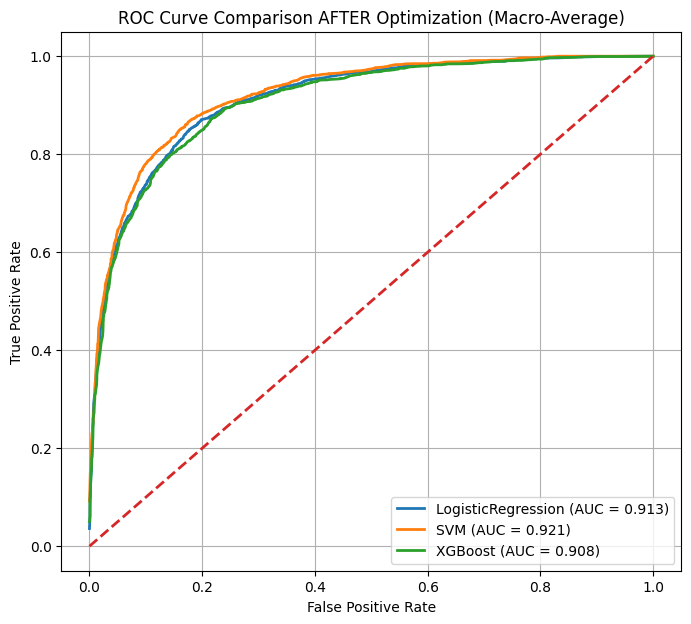

In [16]:
plot_roc_auc_comparison(
    results=results,
    X_test=X_test,
    y_test=y_test_encoded,
    classes=classes
)


In [17]:
import joblib

# Récupérer le modèle Logistic Regression optimisé
best_logistic_model = results["LogisticRegression"]["best_model"]

# Nom du fichier pour sauvegarde
model_filename = "../modele/logistic_model_final.pkl"

# Sauvegarder le modèle
joblib.dump(best_logistic_model, model_filename)

print(f"Modèle Logistic Regression sauvegardé sous : {model_filename}")


Modèle Logistic Regression sauvegardé sous : ../modele/logistic_model_final.pkl


#  Analyse des Modèles après Optimisation

---

## Résumé des performances

- **Gap train–test faible (2 %)**  
   Excellente capacité de généralisation.

- **AUC proche du meilleur modèle (0.913 vs 0.921)**  
   Performance presque aussi bonne que le SVM.

- **Modèle simple, robuste et interprétable**  
   Idéal pour la production ou pour expliquer les prédictions.

- **SVM**  
   Gap élevé (9 %) → signe de sur-apprentissage.

---

##  Conclusion

La **régression logistique** offre le **meilleur compromis** entre **performance** et **robustesse**.
